In [5]:
import numpy as np
import matplotlib.pyplot as plt
from biosppy.signals import ecg
import scipy.signal as ss
from neurokit2 import ecg_delineate
from tqdm import tqdm
import pandas as pd

In [64]:
# Load data
def load_data(train_path, test_path):
    train = pd.read_csv(train_path, index_col="id")
    test = pd.read_csv(test_path, index_col="id")
    return train, test

# Handle NaNs and normalize
def preprocess_signals(data):
    # Fill NaNs with 0
    data = data.fillna(0)
    # Normalize each signal
    signal_cols = [col for col in data.columns if col.startswith('x')]
    data[signal_cols] = data[signal_cols].apply(lambda x: (x - x.mean()) / x.std(), axis=1)
    return data

# Load train and test data
train_path = "data/train.csv"
test_path = "data/test.csv"
train, test = load_data(train_path, test_path)

# Preprocess
train = preprocess_signals(train)
test = preprocess_signals(test)

# Verify
print(f"Train shape: {train.shape}, Test shape: {test.shape}")


Train shape: (5117, 17808), Test shape: (3411, 17807)


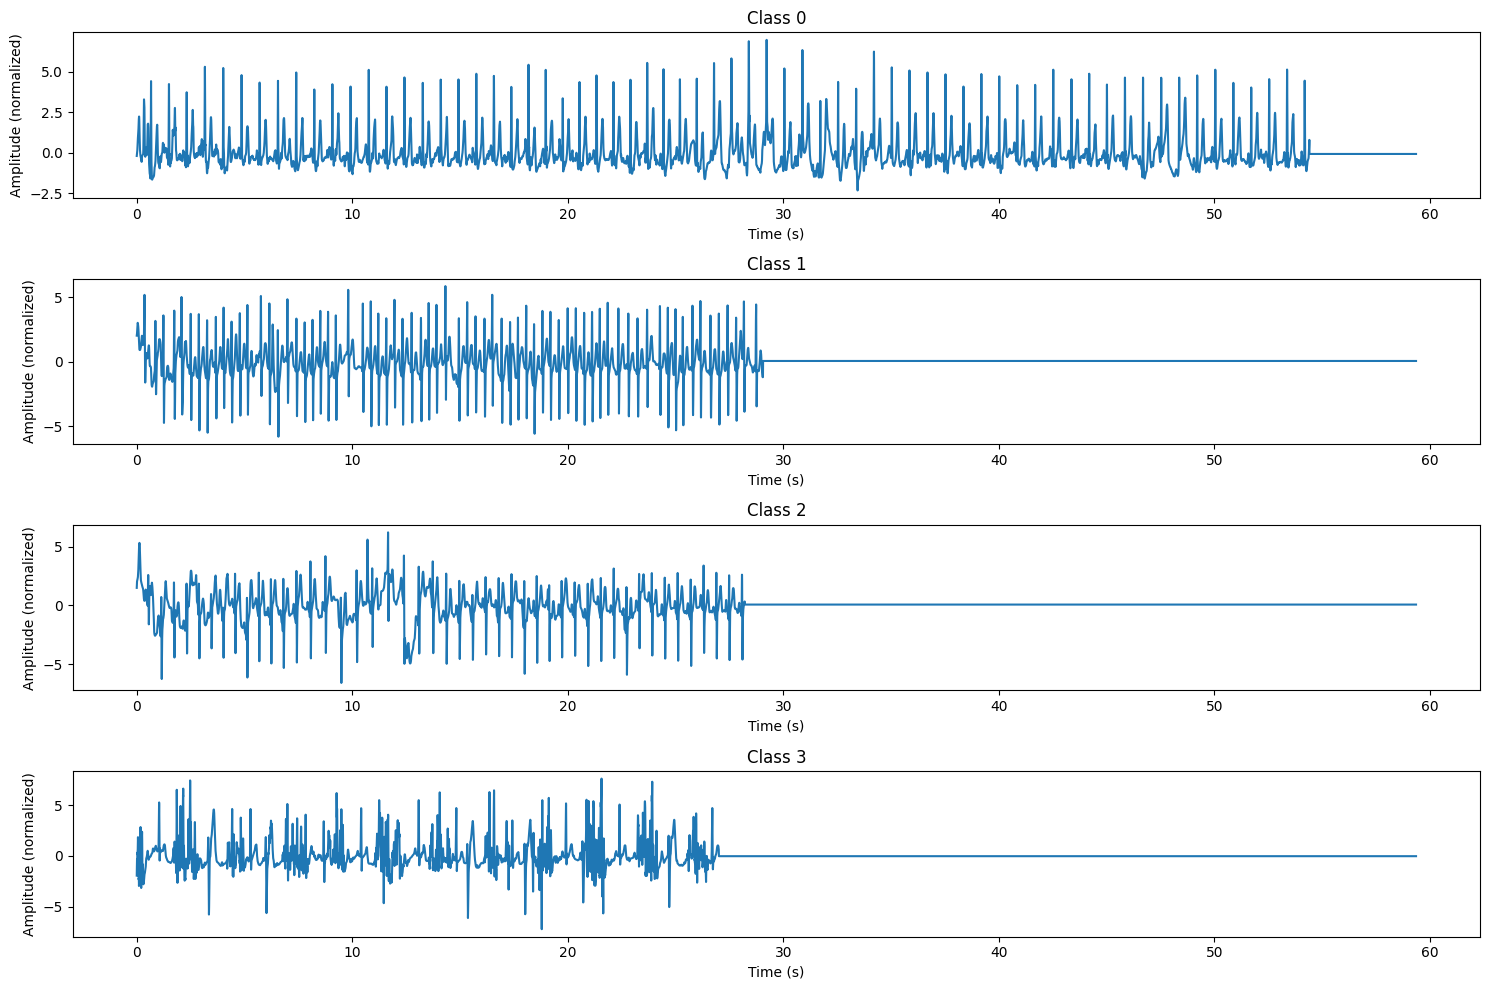

In [3]:
def plot_ecg_classes(data, labels_col="y", num_classes=4):
    labels_array = data[labels_col].to_numpy()
    signal_cols = [col for col in data.columns if col.startswith('x')]

    # Get representative samples for each class
    sample_signal_ids = [np.where(labels_array == i)[0][0] for i in range(num_classes)]
    fig, axs = plt.subplots(num_classes, 1, figsize=(15, 10))

    for i, class_id in enumerate(range(num_classes)):
        signal = data.iloc[sample_signal_ids[i]][signal_cols].dropna().to_numpy(dtype="float32")
        time = np.arange(len(signal)) / 300  # Sampling rate = 300Hz
        axs[i].plot(time, signal)
        axs[i].set_title(f"Class {class_id}")
        axs[i].set_xlabel("Time (s)")
        axs[i].set_ylabel("Amplitude (normalized)")

    plt.tight_layout()
    plt.show()

# Plot ECG samples by class
plot_ecg_classes(train)

In [6]:
def extract_features(signal, sampling_rate=300):
    features = {}
    try:
        # Patch scipy.signal.hamming only if it doesn't exist
        if not hasattr(ss, "hamming"):
            ss.hamming = np.hamming
            
        # Patch scipy.signal.boxcar if missing
        if not hasattr(ss, "boxcar"):
            def boxcar(M):
                return np.ones(M)
            ss.boxcar = boxcar
    
        # ECG processing
        _, filtered, rpeaks, _, _, _, heart_rate = ecg.ecg(signal, sampling_rate=sampling_rate, show=False)
        
        # Basic Features
        features["num_rpeaks"] = len(rpeaks)
        features["mean_heart_rate"] = np.mean(heart_rate) if len(heart_rate) > 0 else 0
        features["std_heart_rate"] = np.std(heart_rate) if len(heart_rate) > 0 else 0

        # Frequency Domain Features
        freq = np.fft.rfftfreq(len(signal), 1 / sampling_rate)
        spectrum = np.abs(np.fft.rfft(signal))
        features["fft_peak_freq"] = freq[np.argmax(spectrum)]
        features["fft_mean"] = np.mean(spectrum)
        features["fft_std"] = np.std(spectrum)

    except Exception as e:
        print(f"Error processing signal: {e}")
        features = {k: 0 for k in ["num_rpeaks", "mean_heart_rate", "std_heart_rate", "fft_peak_freq", "fft_mean", "fft_std"]}
    
    return features

In [7]:
def extract_features_from_df(data, sampling_rate=300):
    feature_list = []
    signal_cols = [col for col in data.columns if col.startswith('x')]

    # Use tqdm to add a progress bar
    for _, row in tqdm(data.iterrows(), total=len(data), desc="Extracting Features"):
        signal = row[signal_cols].to_numpy(dtype="float32")
        features = extract_features(signal, sampling_rate=sampling_rate)
        features["id"] = row.name
        if "y" in data.columns:
            features["label"] = row["y"]
        feature_list.append(features)

    return pd.DataFrame(feature_list)

# Extract features for train and test
train_features = extract_features_from_df(train)
test_features = extract_features_from_df(test)


Extracting Features: 100%|██████████| 3411/3411 [01:27<00:00, 39.15it/s]


In [8]:
print(f"Train features shape: {train_features.shape}, Test features shape: {test_features.shape}")

Train features shape: (5117, 8), Test features shape: (3411, 7)


In [9]:
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import f1_score
from sklearn.pipeline import make_pipeline

# Prepare data for modeling
X = train_features.drop(columns=["id", "label"])
y = train_features["label"]
X_test = test_features.drop(columns=["id"])

# Split data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply oversampling
oversampler = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train, y_train)

# Define pipeline (without RandomOverSampler)
pipeline = make_pipeline(
    StandardScaler(),
    HistGradientBoostingClassifier(random_state=42)
)

# Cross-validation
cv_scores = cross_val_score(pipeline, X_train_resampled, y_train_resampled, cv=5, scoring="f1_micro")
print(f"CV F1 Scores: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

# Train and evaluate
pipeline.fit(X_train_resampled, y_train_resampled)
y_pred = pipeline.predict(X_val)
f1 = f1_score(y_val, y_pred, average="micro")
print(f"Validation F1 Score: {f1:.4f}")


CV F1 Scores: 0.9026 ± 0.0189
Validation F1 Score: 0.6963


In [10]:
# Predict on test set
test_features["y"] = pipeline.predict(X_test)

# Save submission
submission = test_features[["id", "y"]]
submission.to_csv("out/submission1bis.csv", index=False)
print("Submission file created!")

Submission file created!
